In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.python.client import device_lib
from nltk.tokenize import word_tokenize
import time
import collections
import csv
import re
import os
import matplotlib.pyplot as plt
import pylab
import json

In [4]:
model_type = 'Char'

MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
HIDDEN_SIZE = 20
FILTER_SHAPE1 = [20, 20]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
EMBEDDING_SIZE = 20

batch_size = 128
no_epochs = 250
lr = 0.01
use_dropout = False

seed = 10
tf.random.set_seed(seed)

In [5]:
# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpus)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        devices = device_lib.list_local_devices()
        avail_gpu = [x for x in devices if x.device_type == 'GPU']
        print('\n',avail_gpu)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No gpus available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs

 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3048682292
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8164338887902985885
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [6]:
# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

In [7]:
def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict

In [8]:
def preprocess_word(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x

In [9]:
def preprocess_char(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

In [10]:
def read_data_chars_word():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./data/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./data/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))
            
    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess_word(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess_word(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1

    return x_train, y_train, x_test, y_test, vocab_size

In [11]:
def read_data_chars_char():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./data/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./data/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess_char(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess_char(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

In [12]:
def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text

In [26]:
def load_history(model_name, use_dropout):
    if use_dropout:
        with open(f'./histories/{model_name}_dropout') as file:
            history = json.load(file)
    else:
        with open(f'./histories/{model_name}_nodropout') as file:
            history = json.load(file)
    return history

In [14]:
def load_history2(model_name, useClipping):
    if useClipping:
        with open(f'./histories/{model_name}_clipping') as file:
            history = json.load(file)
    else:
        with open(f'./histories/{model_name}_noclipping') as file:
            history = json.load(file)
    return history

In [15]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

In [16]:
# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [17]:
class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(CharRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        if RNN_type == 'GRU2':
            self.rnn = layers.RNN(
                tf.keras.layers.GRUCell(self.hidden_dim), unroll=True, return_sequences=True)
            self.rnn2 = layers.RNN(
                tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        elif RNN_type == 'GRU':
            self.rnn = layers.RNN(
                tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        elif RNN_type == 'Vanilla':
            self.rnn = layers.RNN(
                tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True)
        elif RNN_type == 'LSTM':
            self.rnn = layers.RNN(
                tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, 256)
        x = self.rnn(x)
        if RNN_type == 'GRU2':
            x = self.rnn2(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)

        return logits

In [18]:
class WordRNN(Model):
    def __init__(self, vocab_size, hidden_dim=20):
        super(WordRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        
        # Weight variables and RNN cell
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        if RNN_type == 'GRU2':
            self.rnn = layers.RNN(
                tf.keras.layers.GRUCell(self.hidden_dim), unroll=True, return_sequences=True)
            self.rnn2 = layers.RNN(
                tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        elif RNN_type == 'GRU':
            self.rnn = layers.RNN(
                tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        elif RNN_type == 'Vanilla':
            self.rnn = layers.RNN(
                tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True)
        elif RNN_type == 'LSTM':
            self.rnn = layers.RNN(
                tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)
        
    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)
        if RNN_type == 'GRU2':
            encoding = self.rnn2(encoding)
        encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)

        return logits

In [16]:
RNN_type_ = ['GRU','Vanilla','LSTM','GRU2']
model_type_ = ['Char','Word']
use_clipping = False
model_type = 'Word'

RNN_type = 'LSTM'

if model_type == 'Char':
    x_train, y_train, x_test, y_test = read_data_chars_char()
else:
    x_train, y_train, x_test, y_test, vocab_size = read_data_chars_word()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Build model
tf.keras.backend.set_floatx('float32')
if model_type == 'Char':
    model = CharRNN(256,hidden_dim=HIDDEN_SIZE)
else:
    model = WordRNN(vocab_size, hidden_dim=HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
if use_clipping:
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=2)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [17]:
if model_type == 'Char':
    name = 'CharRNN'
else:
    name = 'WordRNN'
    
print(model_type)

test_acc = []
train_acc = []
test_l = []
train_l = []

start_time = time.time()

drop_rate = 0.5 if use_dropout else 0
print(drop_rate)

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate)  # drop_rate=0 iff not DO_Q5 change to 0.5 for Q5

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate)   # drop_rate=0 iff not DO_Q5 change to 0.5 for Q5

    test_acc.append(test_accuracy.result().numpy().astype(float))
    train_acc.append(train_accuracy.result().numpy().astype(float))
    test_l.append(test_loss.result().numpy().astype(float))
    train_l.append(train_loss.result().numpy().astype(float))

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result())
    print(template)

time_taken = time.time() - start_time

Word
0
Epoch 1, Loss: 2.6668291091918945, Accuracy: 0.07214285433292389, Test Loss: 2.6453518867492676, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6467204093933105, Accuracy: 0.0726785734295845, Test Loss: 2.648606061935425, Test Accuracy: 0.07428571581840515
Epoch 3, Loss: 2.6352498531341553, Accuracy: 0.08142857253551483, Test Loss: 2.5933799743652344, Test Accuracy: 0.12857143580913544
Epoch 4, Loss: 2.315553665161133, Accuracy: 0.1651785671710968, Test Loss: 2.197972297668457, Test Accuracy: 0.19285714626312256
Epoch 5, Loss: 2.009675979614258, Accuracy: 0.23303571343421936, Test Loss: 1.9842089414596558, Test Accuracy: 0.25999999046325684
Epoch 6, Loss: 1.9773857593536377, Accuracy: 0.251964271068573, Test Loss: 2.092674970626831, Test Accuracy: 0.22714285552501678
Epoch 7, Loss: 1.7853374481201172, Accuracy: 0.30714285373687744, Test Loss: 1.7990326881408691, Test Accuracy: 0.33142855763435364
Epoch 8, Loss: 1.5382647514343262, Accuracy: 0.40714284777641296, Test Loss: 1.

Epoch 64, Loss: 0.33211690187454224, Accuracy: 0.9112499952316284, Test Loss: 1.1810264587402344, Test Accuracy: 0.6814285516738892
Epoch 65, Loss: 0.23988524079322815, Accuracy: 0.9346428513526917, Test Loss: 0.8770458102226257, Test Accuracy: 0.8214285969734192
Epoch 66, Loss: 0.07816915214061737, Accuracy: 0.9816071391105652, Test Loss: 0.8934606909751892, Test Accuracy: 0.8242856860160828
Epoch 67, Loss: 0.04421854019165039, Accuracy: 0.991428554058075, Test Loss: 0.8761678338050842, Test Accuracy: 0.8271428346633911
Epoch 68, Loss: 0.030137289315462112, Accuracy: 0.9939285516738892, Test Loss: 0.893721342086792, Test Accuracy: 0.8257142901420593
Epoch 69, Loss: 0.026162056252360344, Accuracy: 0.9948214292526245, Test Loss: 0.9205050468444824, Test Accuracy: 0.8271428346633911
Epoch 70, Loss: 0.025003904476761818, Accuracy: 0.9955357313156128, Test Loss: 0.9279990792274475, Test Accuracy: 0.8199999928474426
Epoch 71, Loss: 0.021355900913476944, Accuracy: 0.996071457862854, Test Los

Epoch 126, Loss: 0.005856912117451429, Accuracy: 0.9989285469055176, Test Loss: 1.4001197814941406, Test Accuracy: 0.7942857146263123
Epoch 127, Loss: 0.004928273148834705, Accuracy: 0.9987499713897705, Test Loss: 1.3966583013534546, Test Accuracy: 0.7985714077949524
Epoch 128, Loss: 0.004427353385835886, Accuracy: 0.9991071224212646, Test Loss: 1.416952133178711, Test Accuracy: 0.7942857146263123
Epoch 129, Loss: 0.004374905023723841, Accuracy: 0.9992856979370117, Test Loss: 1.439283013343811, Test Accuracy: 0.795714259147644
Epoch 130, Loss: 0.00365246320143342, Accuracy: 0.9992856979370117, Test Loss: 1.4474278688430786, Test Accuracy: 0.7942857146263123
Epoch 131, Loss: 0.003506704233586788, Accuracy: 0.9994642734527588, Test Loss: 1.4505327939987183, Test Accuracy: 0.7971428632736206
Epoch 132, Loss: 0.0036327058915048838, Accuracy: 0.9992856979370117, Test Loss: 1.4663738012313843, Test Accuracy: 0.7971428632736206
Epoch 133, Loss: 0.003268363419920206, Accuracy: 0.99928569793701

Epoch 188, Loss: 0.002530068391934037, Accuracy: 0.9998214244842529, Test Loss: 1.3077380657196045, Test Accuracy: 0.8271428346633911
Epoch 189, Loss: 0.002414858667179942, Accuracy: 0.9998214244842529, Test Loss: 1.3223024606704712, Test Accuracy: 0.8271428346633911
Epoch 190, Loss: 0.002303814748302102, Accuracy: 0.9998214244842529, Test Loss: 1.3446084260940552, Test Accuracy: 0.8271428346633911
Epoch 191, Loss: 0.0022267443127930164, Accuracy: 0.9998214244842529, Test Loss: 1.3391481637954712, Test Accuracy: 0.8242856860160828
Epoch 192, Loss: 0.002187058562412858, Accuracy: 0.9998214244842529, Test Loss: 1.3337775468826294, Test Accuracy: 0.8214285969734192
Epoch 193, Loss: 0.0025522916112095118, Accuracy: 0.9996428489685059, Test Loss: 1.3612598180770874, Test Accuracy: 0.8242856860160828
Epoch 194, Loss: 0.002011962002143264, Accuracy: 0.9998214244842529, Test Loss: 1.3472466468811035, Test Accuracy: 0.8242856860160828
Epoch 195, Loss: 0.0019153510220348835, Accuracy: 0.99982142

In [18]:
print(time_taken)

2006.4779810905457


In [19]:
name = name + f'_{RNN_type}'
history = {name: {
    'accuracy': train_acc,
    'val_acc': test_acc,
    'loss': train_l,
    'val_loss': test_l,
    'time_taken': time_taken
}}

In [ ]:
if use_clipping:
    with open(f'./histories/{name}_clipping', 'w') as file:
        json.dump(history, file)
else:
    with open(f'./histories/{name}_noclipping', 'w') as file:
        json.dump(history, file)

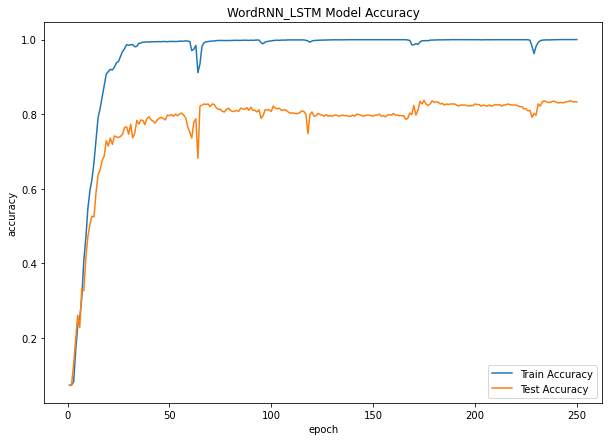

In [27]:
plt.figure(figsize=(10,7))
plt.plot(range(1, len(history[name]['accuracy']) + 1), 
         history[name]['accuracy'], label='Train Accuracy')
plt.plot(range(1, len(history[name]['accuracy']) + 1), 
         history[name]['val_acc'], label='Test Accuracy')
plt.title(f'{name} Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

if use_clipping:
    plt.savefig(
            f'./results/QuestionB6_{name}_acc_clipping.pdf'
        )
else:
    plt.savefig(
            f'./results/QuestionB6_{name}_acc_noclipping.pdf'
        )

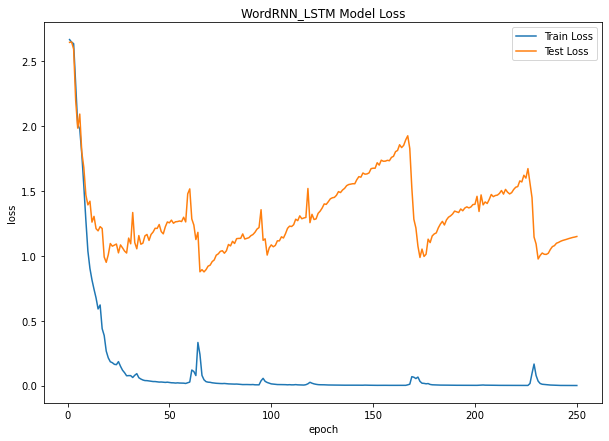

In [28]:
plt.figure(figsize=(10,7))
plt.plot(range(1, len(history[name]['loss']) + 1), 
         history[name]['loss'], label='Train Loss')
plt.plot(range(1, len(history[name]['loss']) + 1), 
         history[name]['val_loss'], label='Test Loss')
plt.title(f'{name} Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

if use_clipping:
    plt.savefig(
            f'./results/QuestionB6_{name}_loss_clipping.pdf'
        )
else:
    plt.savefig(
            f'./results/QuestionB6_{name}_loss_noclipping.pdf'
        )

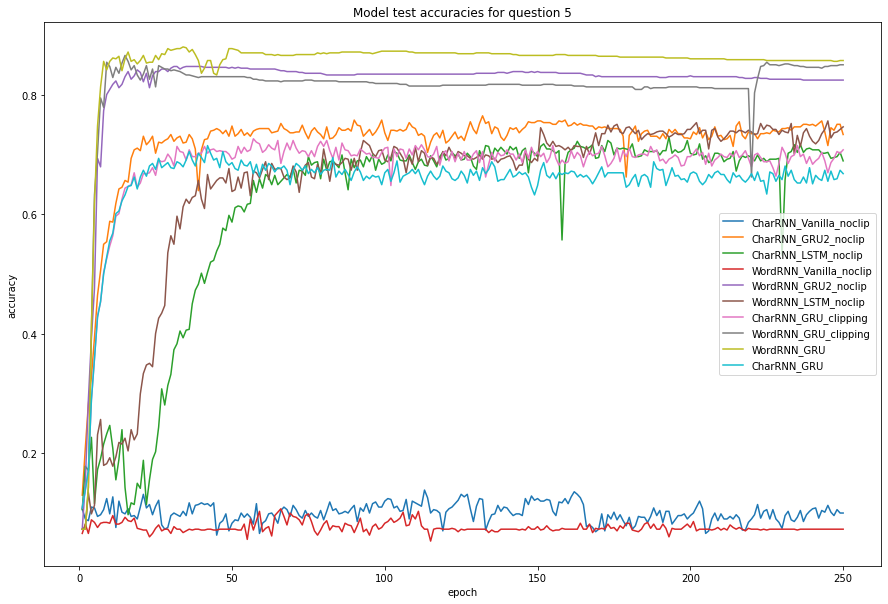

In [33]:
#Display graph for all test accuracies in this question
models = ['CharRNN','WordRNN']
variations = ['Vanilla','GRU2','LSTM']

plt.figure(figsize=(15,10))
histories = {}
for model in models:
    for variation in variations:
        histories[f'{model}_{variation}'] = load_history2(f'{model}_{variation}',False)
        plt.plot(range(1, len(histories[f'{model}_{variation}'][f'{model}_{variation}']['val_acc']) + 1), 
             histories[f'{model}_{variation}'][f'{model}_{variation}']['val_acc'], label=f'{model}_{variation}_noclip')
histories['CharRNN_GRU_clipping'] = load_history2('CharRNN_GRU',True)
plt.plot(range(1, len(histories['CharRNN_GRU_clipping']['CharRNN_GRU']['val_acc']) + 1), 
     histories['CharRNN_GRU_clipping']['CharRNN_GRU']['val_acc'], label='CharRNN_GRU_clipping')
histories['WordRNN_GRU_clipping'] = load_history2('WordRNN_GRU',True)
plt.plot(range(1, len(histories['WordRNN_GRU_clipping']['WordRNN_GRU']['val_acc']) + 1), 
     histories['WordRNN_GRU_clipping']['WordRNN_GRU']['val_acc'], label='WordRNN_GRU_clipping')

histories['WordRNN_GRU'] = load_history('WordRNN',False)
plt.plot(range(1, len(histories['WordRNN_GRU']['WordRNN']['val_acc']) + 1), 
     histories['WordRNN_GRU']['WordRNN']['val_acc'], label='WordRNN_GRU')

histories['CharRNN_GRU'] = load_history('CharRNN',False)
plt.plot(range(1, len(histories['WordRNN_GRU']['WordRNN']['val_acc']) + 1), 
     histories['CharRNN_GRU']['CharRNN']['val_acc'], label='CharRNN_GRU')

plt.title('Model test accuracies for question 5')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='center right')

plt.savefig(
            f'./results/QuestionB6_variation_comparison_all.pdf'
        )

In [34]:
accuracies = {}
for model in models:
    for variation in variations:
        avg_acc = sum(histories[f'{model}_{variation}'][f'{model}_{variation}']['val_acc'][-100:])/100
        accuracies[f'{model}_{variation}'] = avg_acc
avg_acc = sum(histories['CharRNN_GRU_clipping']['CharRNN_GRU']['val_acc'][-100:])/100
accuracies['CharRNN_GRU_clipping'] = avg_acc
avg_acc = sum(histories['WordRNN_GRU_clipping']['WordRNN_GRU']['val_acc'][-100:])/100
accuracies['WordRNN_GRU_clipping'] = avg_acc
avg_acc = sum(histories['WordRNN_GRU']['WordRNN']['val_acc'][-100:])/100
accuracies['WordRNN_GRU'] = avg_acc
avg_acc = sum(histories['CharRNN_GRU']['CharRNN']['val_acc'][-100:])/100
accuracies['CharRNN_GRU'] = avg_acc

for keys in accuracies:
    print(f'{keys}\t\t{accuracies[keys]}')

CharRNN_Vanilla		0.09538571417331695
CharRNN_GRU2		0.7404714238643646
CharRNN_LSTM		0.7002428567409515
WordRNN_Vanilla		0.07248571567237377
WordRNN_GRU2		0.83092857837677
WordRNN_LSTM		0.7334428542852401
CharRNN_GRU_clipping		0.6962285709381103
WordRNN_GRU_clipping		0.8225571376085281
WordRNN_GRU		0.8624571400880814
CharRNN_GRU		0.6641999989748001
